#Data Import

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.pipeline import Pipeline
import pprint
pp = pprint.PrettyPrinter()

In [0]:
from google.colab import drive
drive.mount('/content/Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/Drive


In [0]:
data = pd.read_csv('/content/Drive/My Drive/Colab Notebooks/Project3/advertising.csv')

#Data Exploration

<div>
<img src=https://i.pinimg.com/originals/92/6d/12/926d127280fbd2ef409166c0f2f4fe1c.jpg width="260">
</div>

* Channel selection: Youtube does not seem to have an impact on Sales
* No seasonal trends visible in the data
* Social has a pretty strong linear relationship to sales, as evidenced by the scatter plot and the correlation of 0.90

In [0]:
data

,Day,Social,Google Adwords,Youtube,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,12.0
3,4,151.5,41.3,58.5,16.5
4,5,180.8,10.8,58.4,17.9
...,...,...,...,...,...
195,196,38.2,3.7,13.8,7.6
196,197,94.2,4.9,8.1,14.0
197,198,177.0,9.3,6.4,14.8
198,199,283.6,42.0,66.2,25.5


In [0]:
data.dtypes

Day                 int64
Social            float64
Google Adwords    float64
Youtube           float64
Sales             float64
dtype: object

In [0]:
data.isnull().sum()

Day               0
Social            0
Google Adwords    0
Youtube           0
Sales             0
dtype: int64

In [0]:
data.corr()['Sales']

Day              -0.021306
Social            0.901208
Google Adwords    0.349631
Youtube           0.157960
Sales             1.000000
Name: Sales, dtype: float64

We would drop `Day` and `Youtube`, as the have a low correlation (<0.2) with `Sales`, however wie will keep both for now, due to the low amount of variables overall.

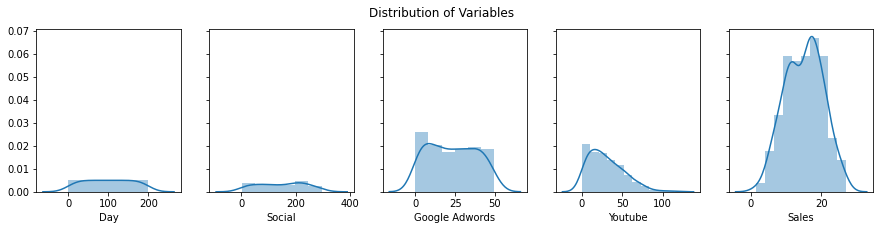

In [0]:
fig, axs = plt.subplots(1,5, figsize=(15,3),sharey=True)

for column, ax in zip(data.columns, axs.flatten()[:5]):
  sns.distplot(data[column],ax=ax)

plt.suptitle('Distribution of Variables')
plt.show()

In [0]:
for column in data.columns:
  print(f'{column}: {data[column].quantile(0.99)}, {data[column].max()}')

Day: 198.01, 200
Social: 292.9069999999999, 296.4
Google Adwords: 49.4, 49.6
Youtube: 89.5149999999999, 114.0
Sales: 25.506999999999994, 27.0


The only variable with noticable outliers is Youtube, but the difference between the 99th percentile and the max seems acceptable. The Distributions are also fairly narrow, another indicator of not having to remove outliers.

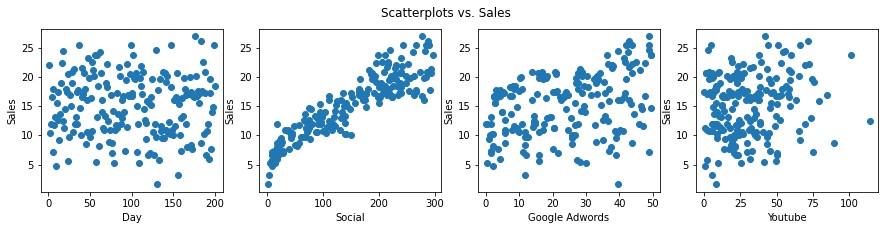

In [0]:
fig, axs = plt.subplots(1,4, figsize=(15,3))

for column, ax in zip(data.columns, axs.flatten()[:4]):
  ax.scatter(data[column],data['Sales'])
  ax.set_xlabel(column)
  ax.set_ylabel('Sales')
plt.suptitle('Scatterplots vs. Sales')
plt.show()

Social has a clear linear trend vs. Sales. The other variables do not show any.

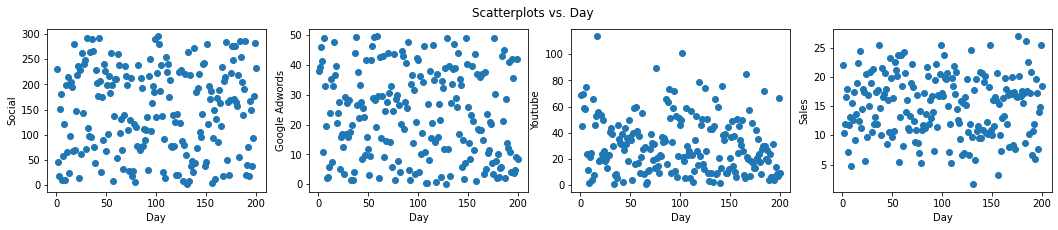

In [0]:
fig, axs = plt.subplots(1,4, figsize=(18,3))

for column, ax in zip(data.columns[1:5], axs.flatten()[:4]):
  ax.scatter(data['Day'],data[column])
  ax.set_xlabel('Day')
  ax.set_ylabel(column)
plt.suptitle('Scatterplots vs. Day')
plt.show()

There seems to be no meaningful seasonal trend within the data. All variables show no significant trend vs. Day.

#OLS Regression

![](https://media.makeameme.org/created/regression.jpg)

* Price elasticity (Based on OLS coefficients without scaling): For every dollar spent on
  * **Social Media**, there is a 5 cents increase in Sales
  * **Google Adwords**, there is a 10 cents increase in Sales.
  * **Youtube**, there is half a cent increase in Sales. (Not statistically significant, p>0.05)

* Channel impact (Based on OLS coefficients with scaling): We see that **Social Media** has about 3 times the impact of **Google Adwords**

* Average Channel Spending: Social 147, Google Adwords 23, Youtube 30. 

$\Rightarrow$ Social Media has a higher impact on Sales because of the higher amount spent on it, however Google Adwords is twice as effective generating twice the amount of Sales per Dollar spent.

* Final Formula
    $ Sales = 0.05 * (Social) + 0.10 * (Google Adwords) + 4.79$
    * This model has an $R^2$ of 0.900 and an MRSE of 1.638
    * Without any Channels 1000ml would still make 4.79$ in Sales per day.
    * We removed Days and Youtube from our model, since they carry no statistical significance.

* Other possible features: Channel reach (clicks, views etc.), user demographic (through user profiles)

In [0]:
data.mean()

Day               100.5000
Social            147.0425
Google Adwords     23.2640
Youtube            30.5540
Sales              15.1305
dtype: float64

The most spending is on Social, with Youtube and Google Adwords being close to each other.

##With all variables
* Google Adwords: 0.10, Social: 0.05, Youtube: 0.00 (insignificant)

In [0]:
#set variables
x = data[['Social','Google Adwords','Youtube']]
y = data['Sales']

#add constant
x = sm.add_constant(x)

#test train split
x_train, x_test, y_train, y_test = train_test_split(
                                          x, y, test_size = 0.2, random_state = 42
                                        )

# run model
lin_model = sm.OLS(y_train, x_train).fit()

lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     468.7
Date:                Wed, 06 May 2020   Prob (F-statistic):           8.51e-78
Time:                        00:48:05   Log-Likelihood:                -305.78
No. Observations:                 160   AIC:                             619.6
Df Residuals:                     156   BIC:                             631.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.7141      0.352     13.407      0.000       4.020       5.409
Social             0.0545      0.002     34.972      0.000       0.051       0.058
Google Adwords     0.1009      0.010     10.470      0.000       0.082       0.120
Youtube            0.0043      0.007      0.619      0.537      -0.010       0.018
==============================================================================
Omnibus:                       13.344   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.080
Skew:                          -0.422   Prob(JB):                     1.60e-05
Kurtosis:                       4.613   Cond. No.                         471.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
#R2 scores
print(f'Train score: {r2_score(y_train,lin_model.predict(x_train)):.3f}')
print(f'Test score: {r2_score(y_test,lin_model.predict(x_test)):.3f}')
#Root MSE Values
print(f'Train root mse: {mean_squared_error(y_train, lin_model.predict(x_train))**0.5:.3f}')
print(f'Test root mse: {mean_squared_error(y_test, lin_model.predict(x_test))**0.5:.3f}')

Train score: 0.900
Test score: 0.906
Train root mse: 1.636
Test root mse: 1.705


## p < 0.05
* Google Adwords: 0.10, Social: 0.05

In [0]:
#set variables
x = data[['Social','Google Adwords']]
y = data['Sales']

#add constant
x = sm.add_constant(x)

#test train split
x_train, x_test, y_train, y_test = train_test_split(
                                          x, y, test_size = 0.2, random_state = 42
                                        )

# run model
lin_model = sm.OLS(y_train, x_train).fit()

lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     705.7
Date:                Wed, 06 May 2020   Prob (F-statistic):           3.43e-79
Time:                        00:48:05   Log-Likelihood:                -305.98
No. Observations:                 160   AIC:                             618.0
Df Residuals:                     157   BIC:                             627.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.7914      0.328     14.606      0.000       4.143       5.439
Social             0.0545      0.002     35.040      0.000       0.051       0.058
Google Adwords     0.1033      0.009     11.641      0.000       0.086       0.121
==============================================================================
Omnibus:                       15.269   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.509
Skew:                          -0.468   Prob(JB):                     1.75e-06
Kurtosis:                       4.760   Cond. No.                         435.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
#R2 scores
print(f'Train score: {r2_score(y_train,lin_model.predict(x_train)):.3f}')
print(f'Test score: {r2_score(y_test,lin_model.predict(x_test)):.3f}')
#Root MSE Values
print(f'Train root mse: {mean_squared_error(y_train, lin_model.predict(x_train))**0.5:.3f}')
print(f'Test root mse: {mean_squared_error(y_test, lin_model.predict(x_test))**0.5:.3f}')

Train score: 0.900
Test score: 0.908
Train root mse: 1.638
Test root mse: 1.687


In [0]:
y_pred = lin_model.predict(x_test)
print(y_pred.mean())
print(data['Sales'].mean())

14.719830412384088
15.130500000000005


In [0]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = float(p.get_height().round(2))
                ax.text(_x, _y, value, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = float(p.get_width().round(2))
                ax.text(_x, _y, value, ha="left", va="bottom")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

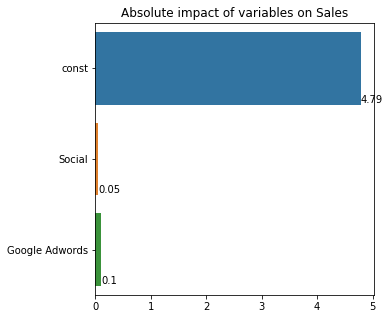

In [0]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.barplot(lin_model.params.abs(), lin_model.params.index,ax=ax)
show_values_on_bars(ax, "h", 0)

plt.title('Absolute impact of variables on Sales')
plt.show()

## With Scaler
* Google Adwords: 0.29, Social: 0.89, Youtube: 0.02 (insignificant)

In [0]:
#set variables
x = data[['Social','Google Adwords','Youtube']]
y = data['Sales']

#test train split
x_train, x_test, y_train, y_test = train_test_split(
                                          x, y, test_size = 0.2, random_state = 42
                                        )

# create a standard scaler for each variable and variable partition
for col in x_train.columns:
  ss_x_train = StandardScaler()
  x_train[col] = ss_x_train.fit_transform(np.array(x_train[col]).reshape(-1,1))

  ss_x_test = StandardScaler()
  x_test[col] = ss_x_test.fit_transform(np.array(x_test[col]).reshape(-1,1))

# fit the fit_transform train set
ss_y_train = StandardScaler()
y_train = ss_y_train.fit_transform(np.array(y_train).reshape(-1,1))

#fit the fit_transform test set
ss_y_test = StandardScaler()
y_test = ss_y_test.fit_transform(np.array(y_test).reshape(-1,1))

#add constant to train and test x
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

# run model
lin_model = sm.OLS(y_train, x_train).fit()

lin_model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     468.7
Date:                Wed, 06 May 2020   Prob (F-statistic):           8.51e-78
Time:                        00:48:05   Log-Likelihood:                -42.710
No. Observations:                 160   AIC:                             93.42
Df Residuals:                     156   BIC:                             105.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.429e-16      0.025   -9.6e-15      1.000      -0.050       0.050
Social             0.8861      0.025     34.972      0.000       0.836       0.936
Google Adwords     0.2878      0.027     10.470      0.000       0.233       0.342
Youtube            0.0170      0.027      0.619      0.537      -0.037       0.071
==============================================================================
Omnibus:                       13.344   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.080
Skew:                          -0.422   Prob(JB):                     1.60e-05
Kurtosis:                       4.613   Cond. No.                         1.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [0]:
#R2 scores
print(f'Train score: {r2_score(y_train,lin_model.predict(x_train)):.3f}')
print(f'Test score: {r2_score(y_test,lin_model.predict(x_test)):.3f}')
#Root MSE Values
print(f'Train root mse: {mean_squared_error(y_train, lin_model.predict(x_train))**0.5:.3f}')
print(f'Test root mse: {mean_squared_error(y_test, lin_model.predict(x_test))**0.5:.3f}')

Train score: 0.900
Test score: 0.913
Train root mse: 0.316
Test root mse: 0.295


In [0]:
y_prediction_test = lin_model.predict(x_test)
y_pred = ss_y_test.inverse_transform(y_prediction_test)
print(y_pred.mean())
print(data['Sales'].mean())

14.330000000000002
15.130500000000005


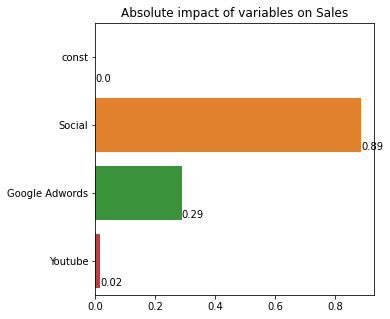

In [0]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.barplot(lin_model.params.abs(), lin_model.params.index,ax=ax)
show_values_on_bars(ax, "h", 0)

plt.title('Absolute impact of variables on Sales')
plt.show()

#Ridge Regression
* The Ridge regression gives about the same results for the coefficients as the OLS Regression. (5 cents per Dollar for Social and 10 cents per Dollar on Google Adwords)

In [0]:
#Set the variable
x = data.drop(columns = ['Day','Sales'])
y = data['Sales']

#test_train_split
x_train, x_test, y_train, y_test = train_test_split(x,
                                                  y,
                                                  test_size = 0.2,
                                                  random_state = 12)

#set alpha range
# alpha_range = [np.power(10,float(number)) for number in range(-5,6)]
alpha_range = range(800,1200)

In [0]:
mydict = {}
s = []

for alpha_num in alpha_range:
  #create ridge model object
  ridge_cv_model = Ridge(alpha = alpha_num)
  
  #set up cross validation
  ridge_cv_scores = cross_validate(ridge_cv_model,
                                    x_train,
                                    y_train,
                                    cv = 10,
                                    scoring=('r2','neg_mean_squared_error'))
  
  #get the mean of scores
  r2_cv_mean = ridge_cv_scores['test_r2'].mean()
  mse_cv_mean = ridge_cv_scores['test_neg_mean_squared_error'].mean()

  mydict[f'{alpha_num}'] = (r2_cv_mean, mse_cv_mean)

  s.append(r2_cv_mean)

In [0]:
alpha_range[np.argmax(s)]

929

In [0]:
import pprint
pp = pprint.PrettyPrinter()

estimator = Ridge(alpha_range[np.argmax(s)])
estimator.fit(x_train,y_train)
pp.pprint(list(zip(x.columns,estimator.coef_)))

[('Social', 0.052833434891692885),
 ('Google Adwords', 0.10850394999491057),
 ('Youtube', -0.00163926778215364)]
